# Анализ систем метрик продукта


* Автор: Игнатьев Валерий
* Дата: 04.01.2026

**Цель проекта:** Выявить причины снижения выручки внутриигрового магазина мобильной игры Mines & Moles с июля 2024 года и сформулировать обоснованные рекомендации для восстановления роста монетизации.

## Описание данных

**Данные пользователей — таблица `users`**
* `device_id` — идентификатор устройства пользователя, на которое установлена игра (type: String);
* `user_id` — идентификатор зарегистрированного в игре пользователя, NULL — если пользователь не зарегистрирован (type: Int);
* `install_time` — дата и время установки приложения (type: DateTime);
* `country_code` — код страны пользователя (определяется по магазину приложений, в котором была скачана игра) (type: String);
* `platform` — операционная система устройства, на которое установлена игра (iOS или Android) (type: String);
* `traffic_type` — тип источника привлечения пользователя (органический, платный, реферальный) (type: String);
* `source` — конкретный источник привлечения пользователя (type: String);
* `campaign` — идентификатор рекламной кампании (только для платного трафика, для остальных — NULL) (type: String).


**Данные о событиях — таблица `events`**
* `device_id` — уникальный идентификатор устройства пользователя (type: String);
* `session_id` — идентификатор сессии пользователя (type: Int);
* `time` — дата и время события (type: DateTime);
* `event_name` — название события (type: String), список событий:
* `app_start` — старт приложения;
* `registration_complete` — прохождение регистрации;
* `game_launched` — запуск игры;
* `store_open` — открытие магазина;
* `item_add_to_cart` — добавление предмета в корзину;
* `checkout_load` — открытие чекаута;
* `order_completed` — завершение заказа.

**Данные о прохождении уровней — таблица `game_sessions`**
* `device_id` — уникальный идентификатор устройства пользователя (type: String);
* `session_id` — идентификатор сессии пользователя (type: Int);
* `level_id` — идентификатор уровня (type: Int);
* `time_start` — дата и время начала прохождения уровня (type: DateTime);
* `time_end` — дата и время окончания прохождения уровня (type: DateTime);
* `success_fact` — завершение уровня пользователем: 1 — завершён, 0 — не завершён (type: Int);
* `duration_sec` — длительность прохождения уровня в секундах (type: Int).

**Данные о транзакциях в игровом магазине — таблица `transactions`**
* `device_id` — уникальный идентификатор устройства пользователя (type: String);
* `session_id` — идентификатор сессии пользователя (type: Int);
* `transaction_id` — идентификатор транзакции (type: Int);
* `time` — дата и время транзакции (type: DateTime);
* `payment_type` — способ оплаты (банковская карта, PayPal, внутриигровой кошелёк) (type: String);
* `item_name` — название товара в магазине (type: String);
* `price` — цена товара в долларах (type: Float);
* `status` — результат транзакции (success — оплата прошла успешно, failed — оплата не прошла) (type: String).



## Задача проекта
Выдвинуть и проверить основные гипотезы падения ключевой метрики выручки через дерево метрик. Изучить метрики и найти взаимосвязи. Дать рекомендации для бизнеса.

### 1. Дерево метрик

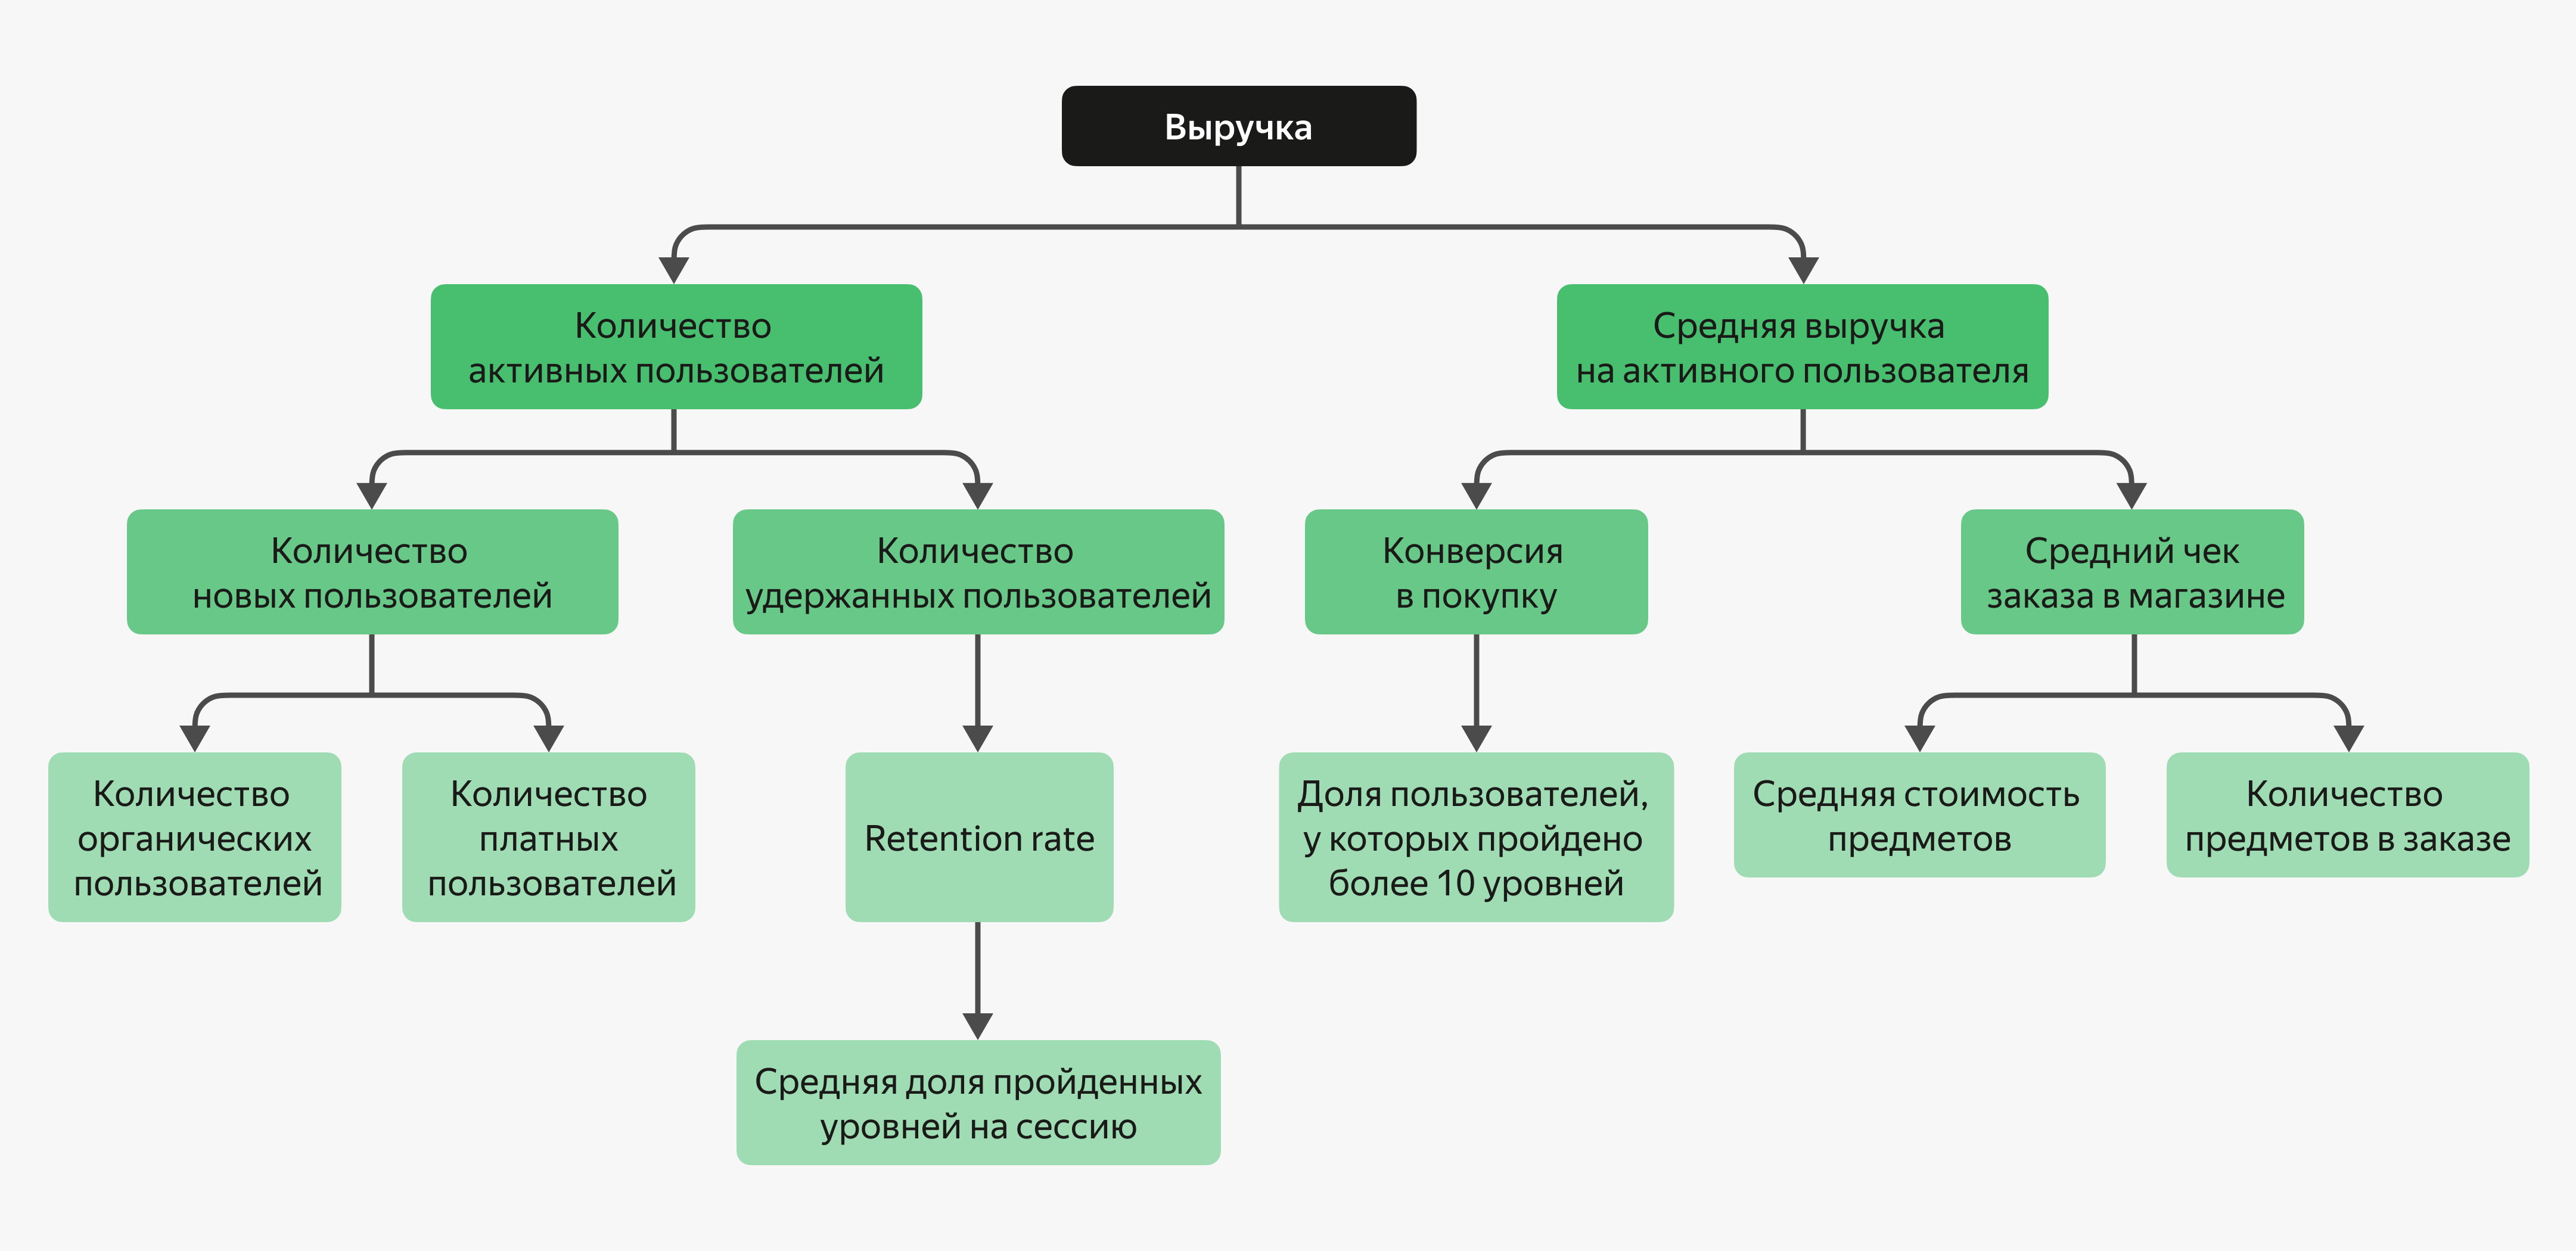

#### **Гипотезы:**
После изучения дерева метрик и потребностей бизнеса можно выдвинуть ряд гипотез:
* Ухудшилась стратегия привлечения новых пользователей.
* Опыт текущих пользователей в игре ухудшается.
* Пользователи стали покупать меньше товаров или более дешёвые товары.
* Пользователи стали менее активно совершать покупки.

#### 1.1. Обработка и агрегирование данных в SQL
Сделаем агрегирование данных в SQL для удобной работы в дальнейшем:



```
--Подготовка датасета для расчета данных для MAU, Retention--
SELECT
    ev.device_id,
    MIN(DATE_TRUNC('month', ev.time)::DATE) OVER(PARTITION BY ev.device_id) AS first_activity_month,
    DATE_TRUNC('month', ev.time)::DATE AS all_activity_month,
    us.platform,
    us.country_code,
    us.traffic_type
FROM mines.events AS ev
LEFT JOIN mines.users AS us ON ev.device_id = us.device_id
WHERE event_name = 'app_start'
GROUP BY ev.device_id, DATE_TRUNC('month', ev.time), us.platform, us.country_code, us.traffic_type;
```



**Формат агрегированных данных:**

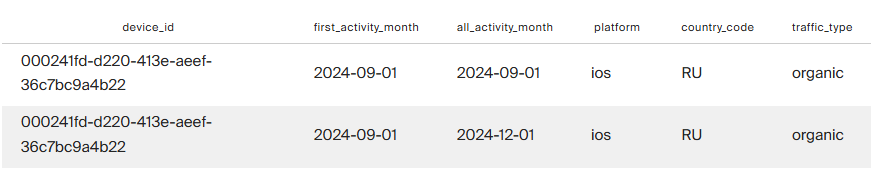


#### 1.2. Расчеты и визуализация
Проверим гипотезы и вызуализируем результаты

In [7]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

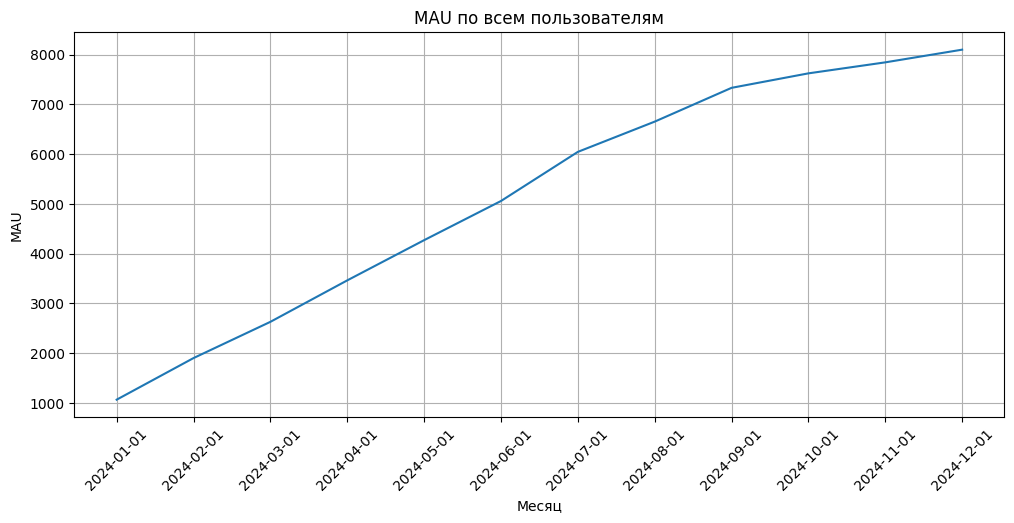

In [3]:
# Изучим MAU по всем пользователям
df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_dataset.csv')

mau_all = df.groupby('all_activity_month')['device_id'].nunique().reset_index()

# Изображаем графики по платформам
plt.figure(figsize=(12,5))
plt.plot(mau_all['all_activity_month'], mau_all['device_id'])
plt.title('MAU по всем пользователям')
plt.xlabel('Месяц')
plt.ylabel('MAU')
plt.xticks(rotation=45)
plt.grid()
plt.show()

**Вывод:**
* Выручка по месяцам начинает падать с июля 2024 года. В то время как MAU показывает стабильный рост из месяца в месяц с замедлением в конце года.
* Несмотря на введение изменений в игру и падение доходов, среднее количество пользователей в месяц продолжает увеличиваться.

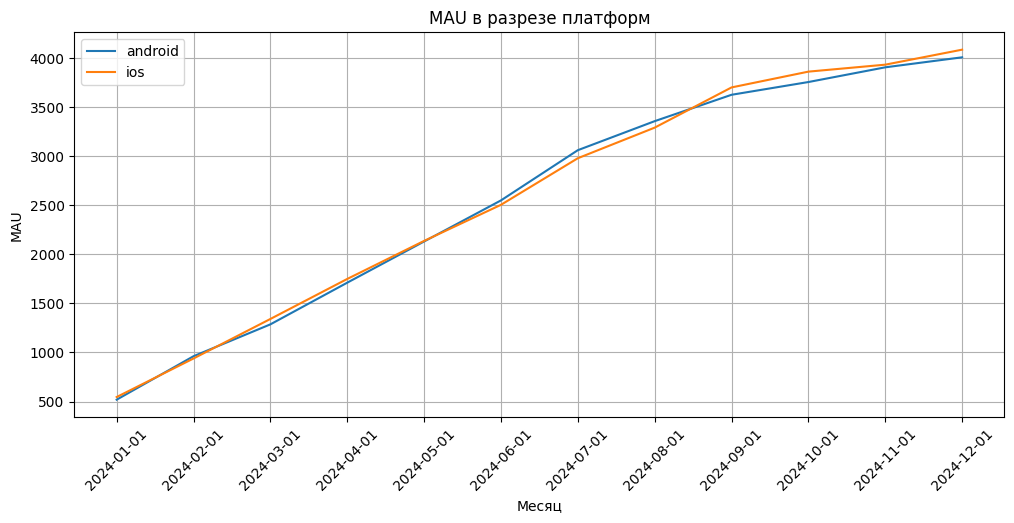

In [4]:
# Изучим MAU в разрезе платформ
# Производим группировку датафрейма на уровне каждого месяца и платформы
mau_platforms = df.groupby(['all_activity_month', 'platform'])['device_id'].nunique().reset_index()

# Изображаем графики по платформам
plt.figure(figsize=(12,5))
for platform in mau_platforms['platform'].unique():
    mau_platform = mau_platforms[mau_platforms['platform']==platform]
    plt.plot(mau_platform['all_activity_month'], mau_platform['device_id'], label=platform)
plt.title('MAU в разрезе платформ')
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('MAU')
plt.xticks(rotation=45)
plt.grid()
plt.show()


**Вывод:**
* MAU в разрезе платформ показывает стабильный рост и растет пропорционально.
* Разница между ростом месячных активных пользователей на android и ios незначительная.

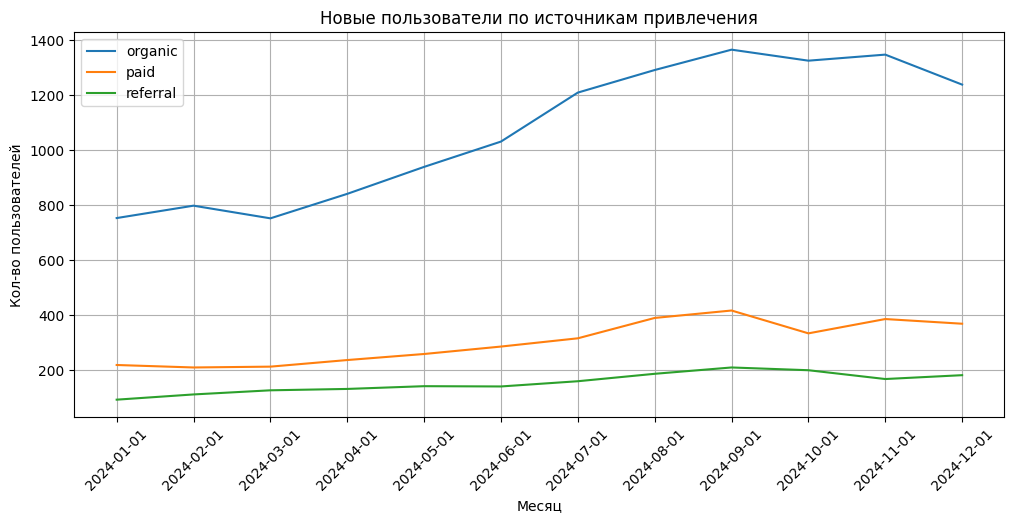

In [5]:
# Изучим новых пользователей по различным каналам привлечения
# Произведем группировку новых пользователей по месяцу и каналу привлечения
new_users = df.groupby(['first_activity_month', 'traffic_type'])['device_id'].nunique().reset_index()

plt.figure(figsize=(12,5))
for traffic_type in new_users['traffic_type'].unique():
    traffic_users = new_users[new_users['traffic_type'] == traffic_type]
    plt.plot(traffic_users['first_activity_month'], traffic_users['device_id'], label=traffic_type)
plt.title('Новые пользователи по источникам привлечения')
plt.legend()
plt.xlabel('Месяц')
plt.ylabel('Кол-во пользователей')
plt.grid()
plt.xticks(rotation=45)
plt.show()


**Вывод:**
* Все  каналы привлечения показывают тенденцию на рост кол-ва пользователей.
* Самый ключевой канал привлечения - organic (органический трафик). Он показывает активный рост с Марта до сентября 2024 года и снижается в декабре (возможен сезонный тренд).
* Платный и реферальный трафик показывают умеренный рост из месяца в месяц с небольшими колебаниями в конце года.


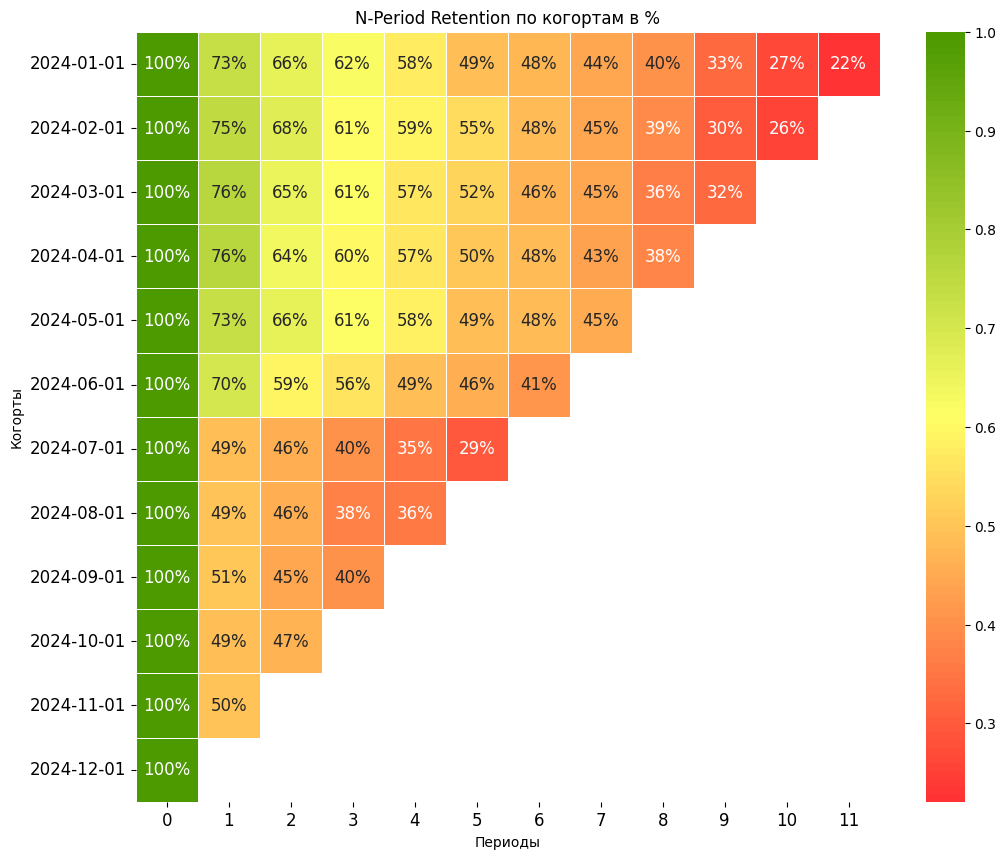

In [8]:
# Изучим Retention rate в когортном анализе
cmap = mcolors.LinearSegmentedColormap.from_list('green_red', ['#FF3333', '#FFFF66', '#4C9900'], N=100)

df['all_activity_month'] = pd.to_datetime(df['all_activity_month'])
df['first_activity_month'] = pd.to_datetime(df['first_activity_month'])

df['n_period'] = df['all_activity_month'].dt.to_period('M').astype('int64') - df['first_activity_month'].dt.to_period('M').astype('int64')
df['first_activity_month'] = df['first_activity_month'].dt.date
data_pivot = pd.pivot_table(
    df,
    values = 'device_id',
    columns = 'n_period',
    index = 'first_activity_month',
    aggfunc = pd.Series.nunique).fillna(0)

data_pivot = data_pivot.div(data_pivot[0], axis=0)
data_pivot[data_pivot == 0] = float('nan')


plt.subplots(figsize=(12,10))
sns.heatmap(data_pivot,
           cmap=cmap,
           annot=True,
           fmt='.0%',
           linewidth=0.5,
           annot_kws={"size": 12})

# Остальные параметры совпадают с линейными графиками на matplotlib
plt.title('N-Period Retention по когортам в %')
plt.xlabel('Периоды')
plt.ylabel('Когорты')
plt.yticks(rotation=0)
plt.tick_params(labelsize=12) # чтобы сделать подписи данных на оси Y (когорты пользователей) немного крупнее
plt.show()

**Вывод:**
* Для когорт с июля и позднее наблюдается сильное уменьшение Retention rate на второй месяц игры. Ранее средний RR на второй месяц игры для когорт составлял  74%, в когортах с июля этот показатель опустился до 50%.
* Такое падение RR может быть связано с ростом новых пользователей в игре и отсутствием их активного удержания и интереса к игре. С июля в игре активнее растет кол-во новых пользователей. Также RR может быть связан с ухудшением пользовательского опыта* или с сезонностью (люди летом предпочитают проводить свободное время не в компьютере).

*С начала лета произошли изменения в пользовательском опыте: редизайн внутриигрового магазина и корректировка алгоритма, который генерирует уровни.*


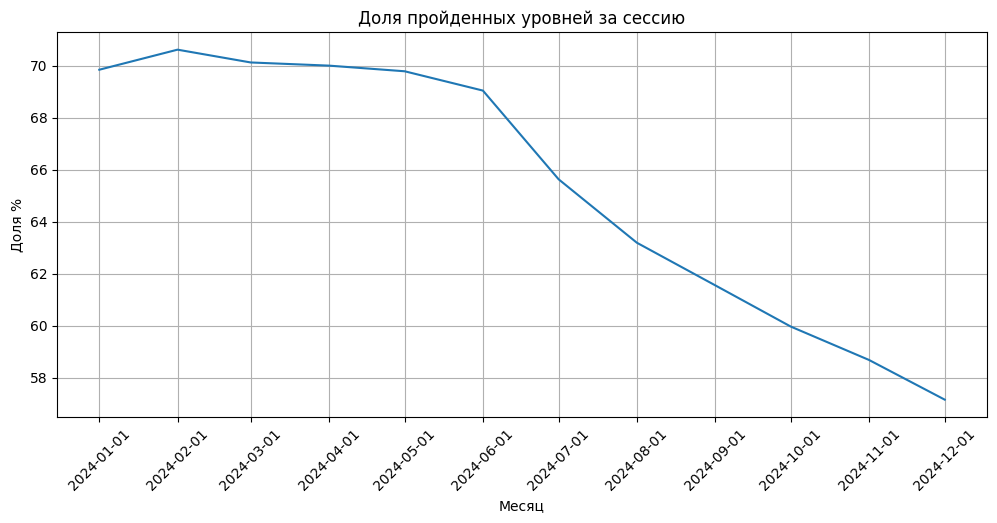

In [11]:
# Изучим среднюю долю кол-во пройденных уровней на сессию
df = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_game_sessions.csv')
df['dt'] = pd.to_datetime(df['time_end']).dt.to_period('M').dt.to_timestamp()

df_group = df.groupby(['dt', 'device_id', 'session_id']).agg(
    success = ('success_fact', 'sum'),
    total = ('success_fact', 'count')
).reset_index()


df_group['success_rate'] = 100*(df_group['success']/df_group['total'])
df_grouped = df_group.groupby('dt')['success_rate'].mean().reset_index()

plt.figure(figsize=(12,5))
plt.plot(df_grouped['dt'], df_grouped['success_rate'])
plt.title('Доля пройденных уровней за сессию')
plt.xlabel('Месяц')
plt.xticks(df_grouped['dt'].unique(), rotation=45)
plt.ylabel('Доля %')
plt.grid()
plt.show()

**Вывод:**
* С июня происходит отрицательная динамика по средней доле пройденных уровней за одну игровую сессию с 69% в июне до 57% в декабре. В этот же период наблюдается низкий RR игроков, которые пришли в этот и более поздний период. Данные изменения могут быть вызваны новой механикой разработки уровней.


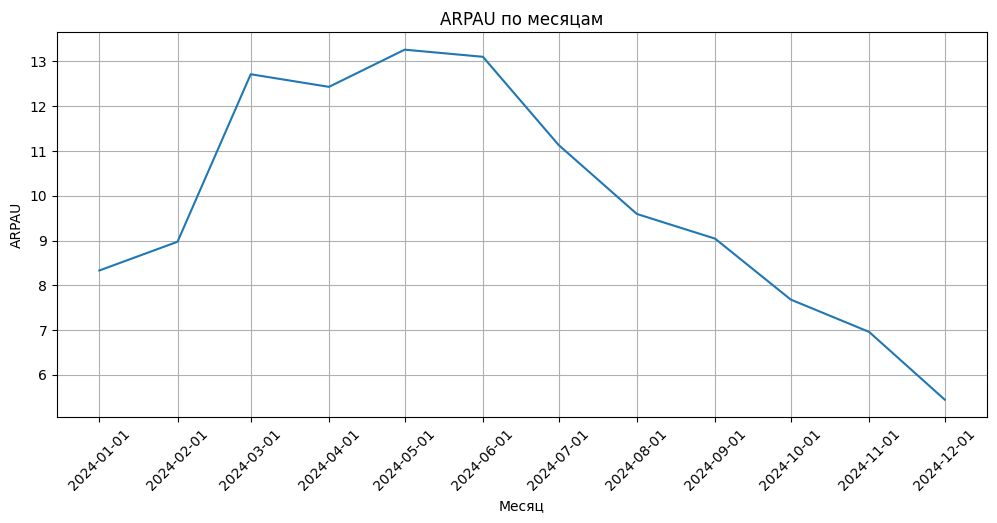

In [12]:
# Расчитаем и проанализируем метрику ARPAU (Среднюю выручку (средний доход) на активного пользователя) по месяцам
transactions = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_transactions.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_events.csv')

transactions['dt'] = pd.to_datetime(transactions['time']).dt.to_period('M').dt.to_timestamp()
events['dt'] = pd.to_datetime(events['time']).dt.to_period('M').dt.to_timestamp()

success_transactions = transactions[transactions['status']=='success']
transactions_sum = success_transactions.groupby('dt')['price'].sum().reset_index()

users_n = events.groupby('dt')['device_id'].nunique().reset_index()

merged_df = transactions_sum.merge(users_n, on='dt', how='left').fillna(0)
merged_df['ARPAU'] = merged_df['price']/merged_df['device_id']

plt.figure(figsize=(12,5))
plt.plot(merged_df['dt'], merged_df['ARPAU'])
plt.title('ARPAU по месяцам')
plt.xlabel('Месяц')
plt.ylabel('ARPAU')
plt.xticks(merged_df['dt'].unique(), rotation=45)
plt.grid()
plt.show()

**Вывод:**
* Средний доход на пользователя показывает сильное падение MbM с июля месяца, несмотря на рост новых пользователей и MAU.

   install_month  store_open
0     2024-01-01         520
1     2024-02-01         498
2     2024-03-01         505
3     2024-04-01         575
4     2024-05-01         630
5     2024-06-01         605
6     2024-07-01         635
7     2024-08-01         721
8     2024-09-01         784
9     2024-10-01         755
10    2024-11-01         828
11    2024-12-01         814
   install_month  item_add_to_cart
0     2024-01-01               441
1     2024-02-01               431
2     2024-03-01               448
3     2024-04-01               498
4     2024-05-01               532
5     2024-06-01               431
6     2024-07-01               102
7     2024-08-01               140
8     2024-09-01               142
9     2024-10-01               153
10    2024-11-01               137
11    2024-12-01               120
   install_month  checkout_load
0     2024-01-01            348
1     2024-02-01            344
2     2024-03-01            354
3     2024-04-01            392
4     20

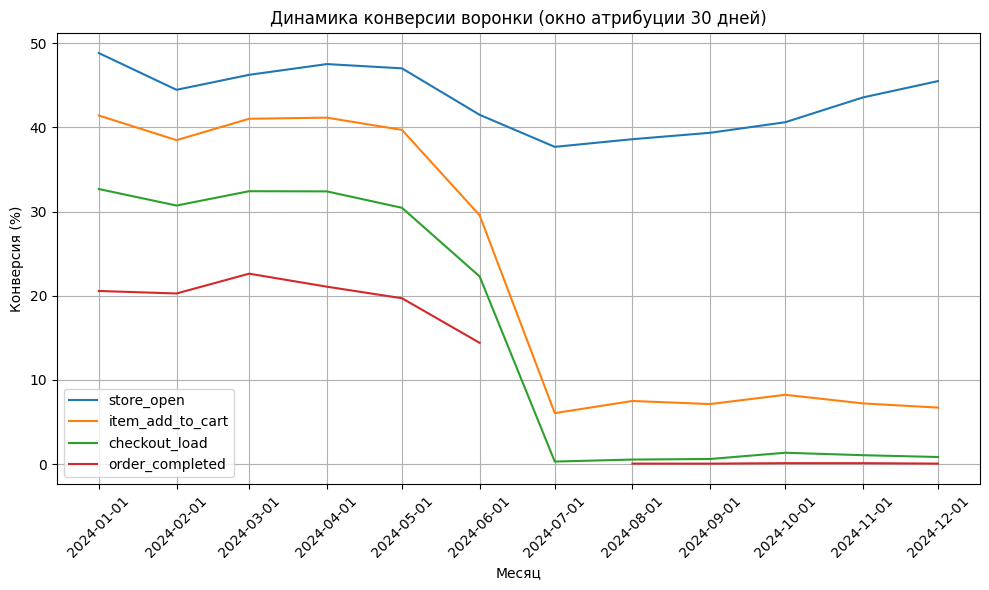

In [14]:
# Расчитаем и проанализируем воронку пользователя с окном аттрибуции 30 дней
events = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_events.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_users.csv')
events['time'] = pd.to_datetime(events['time'])
users['install_time'] = pd.to_datetime(users['install_time'])

df = pd.merge(events, users[['device_id', 'install_time']], on='device_id', how='left')

attribution_window = 30

df['diff_days'] = (df['time'] - df['install_time']).dt.days
df['install_month'] = df['install_time'].dt.to_period('M').dt.to_timestamp()
df = df[df['diff_days'].between(0, attribution_window)]
event_list = ['store_open', 'item_add_to_cart', 'checkout_load', 'order_completed']
funnel_dynamic = df.groupby('install_month')['device_id'].nunique().reset_index(name='install_devices')

plt.figure(figsize=(10, 6))

for event in event_list:
    df_event = df[df['event_name'] == event]
    df_event = df_event.groupby('install_month')['device_id'].nunique().reset_index(name=event)
    print(df_event)
    funnel_dynamic = funnel_dynamic.merge(df_event, on='install_month', how='left')
    funnel_dynamic[event] = (funnel_dynamic[event] / funnel_dynamic['install_devices']) * 100
    plt.plot(funnel_dynamic['install_month'], funnel_dynamic[event], label=event)

plt.title('Динамика конверсии воронки (окно атрибуции 30 дней)')
plt.xlabel('Месяц')
plt.ylabel('Конверсия (%)')
plt.xticks(funnel_dynamic['install_month'].unique(), rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Вывод:**
* Воронка на этапе открытия страницы магазина в июне-июле показала падение, затем рост.
* Добавление в корзину, открытие чекаута и завершение заказа снизились значительно.
* Чекаут и завершение заказа почти исчезли в 6-8 месяцах. Падение связано с проблемами в магазине или отсутствием интереса к покупкам. Новый трафик интересуется магазином (конверсия в открытие магазина 40-45%).
* Падение конверсии на этапе открытия магазина в июне-июле связано с новыми пользователями, осваивающими интерфейс или не нуждающимися в покупках вначале игры.


/tmp/ipython-input-1552603851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success_transactions['month'] = pd.to_datetime(success_transactions['time']).dt.to_period('M').dt.to_timestamp()


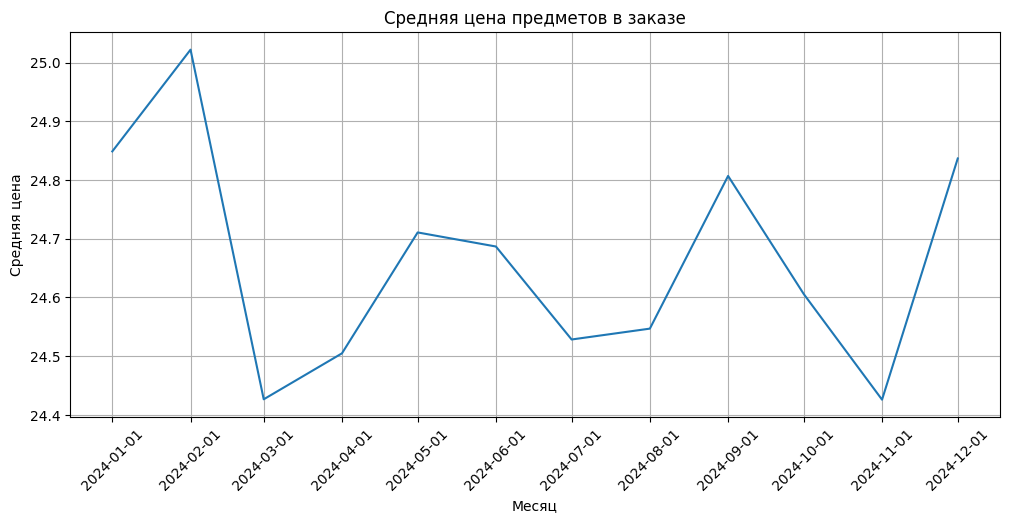

In [16]:
# Выполним расчёт и визуализацию метрики «Средняя цена предметов в заказе» с группировкой по месяцам
transactions = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_transactions.csv')

success_transactions = transactions[transactions['status']=='success']
success_transactions['month'] = pd.to_datetime(success_transactions['time']).dt.to_period('M').dt.to_timestamp()
grouped_transactions = success_transactions.groupby('month').agg(
   price_sum=('price', 'sum'),
   item_quantity=('price', 'count')
).reset_index()
grouped_transactions['avg_item_price'] = grouped_transactions['price_sum']/grouped_transactions['item_quantity']

plt.figure(figsize=(12, 5))
plt.plot(grouped_transactions['month'], grouped_transactions['avg_item_price'])
plt.title('Средняя цена предметов в заказе')
plt.xlabel('Месяц')
plt.ylabel('Средняя цена')
plt.xticks(grouped_transactions['month'].unique(), rotation=45)
plt.grid(True)
plt.show()

**Вывод:**
* График средней цены предмета в заказе довольно волатильный, но средняя цена из месяца в месяц колеблется в районе 0.6. Явного спада в период падения выручки не наблюдается, скорее всего это происходит из-за недостаточности данных (кол-во покупок после июня равно 0-2 штукам в месяц)

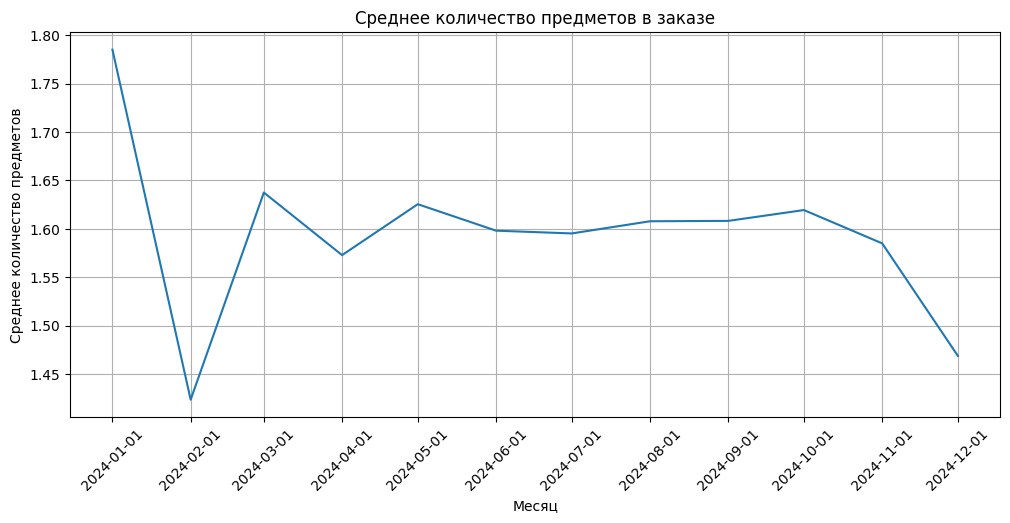

In [17]:
# Выполним расчёт и визуализацию метрики «Среднее количество предметов в заказе за период» с группировкой по месяцам
grouped_transactions = success_transactions.groupby('month').agg(
   order_quantity=('transaction_id', 'nunique'),
   item_quantity=('transaction_id', 'count')
).reset_index()

grouped_transactions['avg_item_count'] = grouped_transactions['item_quantity']/grouped_transactions['order_quantity']

plt.figure(figsize=(12, 5))
plt.plot(grouped_transactions['month'], grouped_transactions['avg_item_count'])
plt.title('Среднее количество предметов в заказе')
plt.xlabel('Месяц')
plt.ylabel('Среднее количество предметов')
plt.xticks(grouped_transactions['month'].unique(), rotation=45)
plt.grid(True)
plt.show()

**Вывод:**
* График среднего кол-ва предметов в заказе показывает пик в январе и сильный спад в феврале, но затем среднее кол-во предметов нормализуется.
* Явного спада в период падения выручки не наблюдается, скорее всего это происходит из-за недостаточности данных (кол-во покупок после июня 0-2 шт в месяц)


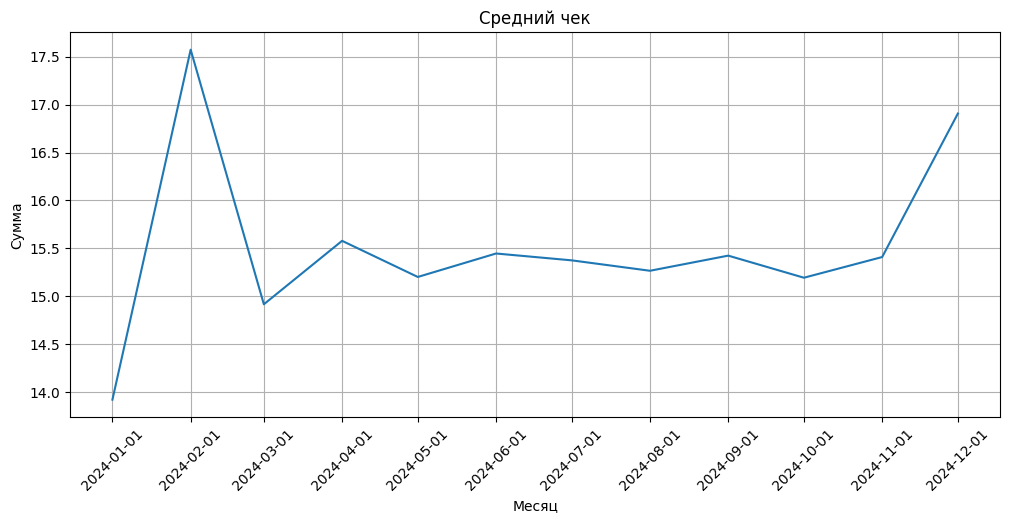

In [18]:
# Выполним расчёт и визуализацию метрики «Cредний чек» с группировкой по месяцам
grouped_transactions = success_transactions.groupby('month').agg(
   order_quantity=('transaction_id', 'nunique'),
   item_quantity=('transaction_id', 'count'),
   price_sum=('price', 'sum')
).reset_index()

grouped_transactions['avg_item_count'] = grouped_transactions['item_quantity']/grouped_transactions['order_quantity']
grouped_transactions['avg_item_price'] = grouped_transactions['price_sum']/grouped_transactions['item_quantity']
grouped_transactions['AOV'] = grouped_transactions['avg_item_price']/grouped_transactions['avg_item_count']

plt.figure(figsize=(12, 5))
plt.plot(grouped_transactions['month'], grouped_transactions['AOV'])
plt.title('Средний чек')
plt.xlabel('Месяц')
plt.ylabel('Сумма')
plt.xticks(grouped_transactions['month'].unique(), rotation=45)
plt.grid(True)
plt.show()

**Вывод:**
* График среднего чека показывает сильный спад в январе и пик в феврале, но затем среднее кол-во из месяца в месяц нормализуется.
* Комбинация пиков и спадов в январе и феврале на графиках Среднего чека и среднего кол-ва предметов в заказе держит выручку на одном уровне.
* В январе было больше предметов, но они были дешевле, в феврале было меньше предметов, но они дороже.
* Аналогично прошлым графикам необходимо учесть недостаточность данных о покупках в месяцы падения выручки.


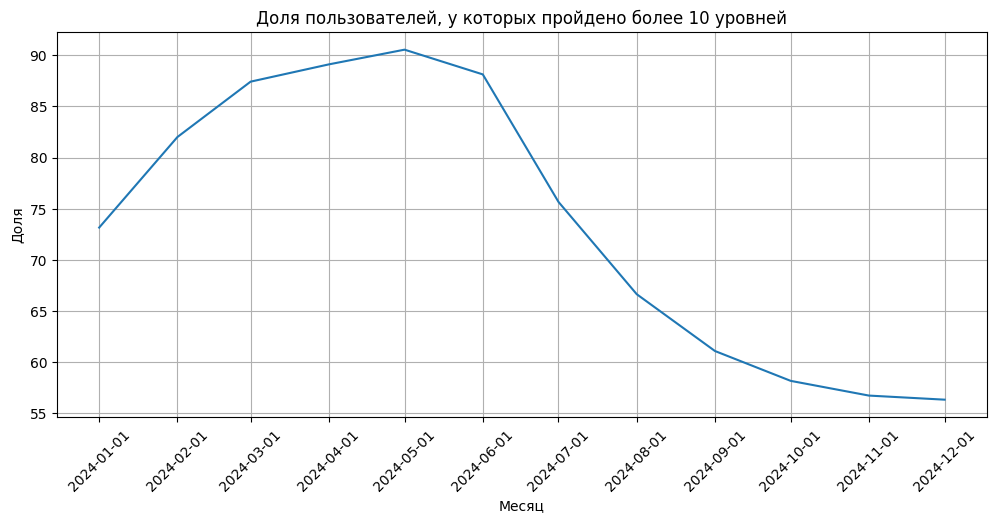

In [19]:
# Выполним расчёт и визуализацию метрики доли пользователей, у которых пройдено более 10 уровней
game_sessions = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_game_sessions.csv')
users = pd.read_csv('https://code.s3.yandex.net/datasets/PA_2_7_1_users.csv')

game_sessions['month'] = pd.to_datetime(game_sessions['time_end']).dt.to_period('M').dt.to_timestamp()
users['month'] = pd.to_datetime(users['install_time']).dt.to_period('M').dt.to_timestamp()


df_levels = game_sessions[game_sessions['success_fact']==1]
df_levels_grouped = df_levels[df_levels['level_id']==11].groupby('month')['device_id'].nunique().reset_index()
df_levels_grouped['cumsum_users_level_success'] =df_levels_grouped['device_id'].cumsum()

df_users_grouped = users.groupby('month')['device_id'].nunique().reset_index()
df_users_grouped['cumsum_users_all'] = df_users_grouped['device_id'].cumsum()

table_final = pd.merge(df_levels_grouped,
                       df_users_grouped,
                       how = 'left', on = 'month')

table_final['levels_finish_rate'] = round(100 * (table_final['cumsum_users_level_success']/table_final['cumsum_users_all']), 2)

plt.figure(figsize=(12, 5))
plt.plot(table_final['month'], table_final['levels_finish_rate'])
plt.title('Доля пользователей, у которых пройдено более 10 уровней')
plt.xlabel('Месяц')
plt.ylabel('Доля')
plt.xticks(table_final['month'].unique(), rotation=45)
plt.grid(True)
plt.show()

**Вывод:**
* Доля пользователей, у которых пройдено более 10 уровней начинает падать с июля, как и выручка игры (с 90% в мае до 57% в декабре).  
* Этот тренд вместе с ростом новых пользователей в эти месяцы может указывать на проблему с прохождением первых уровней и отсутствием интереса у пользователей продолжать играть и покупать в магазине.


#### 1.3. Вывод по результатам исследовательского анализа метрик

**Выводы:**
- В начале 2024 года наблюдался активный рост выручки, однако с июля 2024 года начались стагнация, а затем и уменьшение выручки от месяца к месяцу.
- Общее количество активных пользователей (MAU) и по платформам демонстрирует устойчивый рост, который происходит пропорционально каждый месяц. Новые пользователи также показывают стабильное увеличение из месяца в месяц. Основной способ привлечения пользователей — органический.
- Средний доход на пользователя показывает сильное падение с июля месяца. Средняя цена, стоимость и кол-во предметов из месяца в месяц остаются примерно на одном уровне, хотя наблюдаются небольшие колебания. Однако из-за изменений в воронке конверсии в покупку с июня данные за эти месяцы теряют аналитическую ценность. Конверсия в открытие магазина остается относительно стабильной с небольшим спадом в июне-июле, а затем с возвращением к среднему значению.
- С июня отмечается снижение средней доли пройденных уровней за одну игровую сессию — с 69% в июне до 57% в декабре. Также уменьшается доля пользователей, прошедших более 10 уровней — с 90% в мае до 57% в декабре.
- Для когорт, сформированных с июля и позже, наблюдается значительное снижение показателя Retention rate на второй месяц игры. До июля средний RR на второй месяц составлял 74%, но в новых когортах этот показатель снизился до 50%.

**Рекомендации:**
* Игроки продолжают интересоваться игрой, новые пользователи и MAU растут. Органический трафик указывает на его качество. 40-45% игроков заходят в магазин, но покупают редко (0-2 шт. в месяц с июля). Снижение выручки связано с новым алгоритмом генерации уровней, ухудшающим пользовательский опыт (падение доли пройденных уровней и пользователей, прошедших более 10 уровней).
* Проанализировать и изменить алгоритм генерации уровней, если это не противоречит концепции игры.
* Разработать лимитированные предметы со специальной ценой для ускорения прохождения уровней и мотивации покупок.